# Data processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv('../../data/data_2g.csv')
raw_data = raw_data.fillna(-110)  # missing value 

# type conversion
raw_data['IMSI']= raw_data['IMSI'].astype('int')
raw_data['MRTime']= raw_data['MRTime'].astype('int')
for i in range(1, 8):
    raw_data[f'RNCID_{i}'] = raw_data[f'RNCID_{i}'].astype('int')
    raw_data[f'CellID_{i}'] = raw_data[f'CellID_{i}'].astype('int')
    raw_data[f'AsuLevel_{i}'] = raw_data[f'AsuLevel_{i}'].astype('int')
    raw_data[f'SignalLevel_{i}'] = raw_data[f'SignalLevel_{i}'].astype('int')
    raw_data[f'RSSI_{i}'] = raw_data[f'RSSI_{i}'].astype('int')

# station data
station_data = pd.read_csv('../../data/2g_gongcan.csv')
station_data['RNCID'] = station_data['RNCID'].astype(int)
station_data['CellID'] = station_data['CellID'].astype(int)
    
raw_data[['Longitude', 'Latitude']].describe()

,Longitude,Latitude
count,6096.000000,6096.000000
mean,121.211083,31.287630
std,0.003465,0.003145
min,121.201205,31.281757
25%,121.209179,31.284902
50%,121.212079,31.287601
75%,121.213316,31.289905
max,121.218329,31.293393


In [3]:
imsi_dict = {}
for i, key in enumerate(set(list(raw_data['IMSI']))):
    imsi_dict[key] = i + 1

def replace_IMSI(imsi):
    return imsi_dict[imsi]
func_IMSI = np.vectorize(replace_IMSI)
raw_data['IMSI'] = func_IMSI(raw_data['IMSI'])
raw_data['IMSI'] = raw_data['IMSI'].astype('int')

In [4]:
from haversine import haversine
import math

LONGITUDE_RANGE = [121.20120490000001, 121.2183295]
LATITUDE_RANGE = [31.28175691, 31.29339344]
CASTER_UNIT = 20 # meter
dist_X = haversine((LATITUDE_RANGE[0], LONGITUDE_RANGE[0]), (LATITUDE_RANGE[0], LONGITUDE_RANGE[1])) # in kilometers
dist_Y = haversine((LATITUDE_RANGE[0], LONGITUDE_RANGE[0]), (LATITUDE_RANGE[1], LONGITUDE_RANGE[0])) # in kilometers

caster_num_x = int(np.ceil(dist_X * 1000 / CASTER_UNIT))
caster_num_y = int(np.ceil(dist_Y * 1000 / CASTER_UNIT))
print('The x-caster number:', caster_num_x)
print('The y-caster number:', caster_num_y)

STRIDE_X = (LONGITUDE_RANGE[1] - LONGITUDE_RANGE[0]) / caster_num_x
STRIDE_Y = (LATITUDE_RANGE[1] - LATITUDE_RANGE[0]) / caster_num_y
print('The stride length for longtitude =', STRIDE_X)
print('The stride length for latitude =', STRIDE_Y)

The x-caster number: 82
The y-caster number: 65
The stride length for longtitude = 0.0002088365853657107
The stride length for latitude = 0.00017902353846154667


In [5]:
def coordinate_to_raster(longitude, latitude):
    x = math.floor((longitude - LONGITUDE_RANGE[0]) / STRIDE_X)
    y = math.floor((latitude - LATITUDE_RANGE[0]) / STRIDE_Y)
    raster = int(y * caster_num_x + x)
    return raster

    
def raster_to_longitude(raster):
    x = raster % caster_num_x
    lon = LONGITUDE_RANGE[0] + (x + 0.5) * STRIDE_X
    return lon #raster_to_cordinate(raster)[0]
    
def raster_to_latitude(raster):
    y = raster // caster_num_x
    lat = LATITUDE_RANGE[0] +  (y + 0.5) * STRIDE_Y
    return lat #raster_to_cordinate(raster)[1]
    
func_c2r = np.vectorize(coordinate_to_raster) # the Generalized function
raw_data['raster'] = func_c2r(raw_data['Longitude'], raw_data['Latitude'])
func_r2lon = np.vectorize(raster_to_longitude)
func_r2lat = np.vectorize(raster_to_latitude)
raw_data['r_longitude'] = func_r2lon(raw_data['raster'])
raw_data['r_latitude'] = func_r2lat(raw_data['raster'])

In [6]:
def draw_BG_line():
    # draw the vertical line
    x = LONGITUDE_RANGE[0]
    for i in range(caster_num_x):
        x += STRIDE_X
        plt.vlines(x, ymin=LATITUDE_RANGE[0], ymax=LATITUDE_RANGE[1], color='orange', linewidth=0.5, alpha=0.4)
    
    # draw the horizontal line
    y = LATITUDE_RANGE[0]
    for i in range(caster_num_y):
        y += STRIDE_Y
        plt.hlines(y, xmin=LONGITUDE_RANGE[0], xmax=LONGITUDE_RANGE[1], color='orange', linewidth=0.5, alpha=0.4)

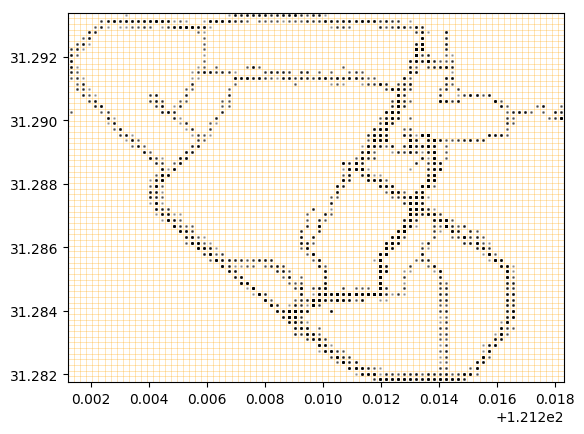

In [7]:
plt.style.use('default')
plt.scatter(raw_data['r_longitude'], raw_data['r_latitude'], color='black', s=1, alpha=0.25)

plt.xlim(LONGITUDE_RANGE)
plt.ylim(LATITUDE_RANGE)

draw_BG_line()

plt.savefig('scatter_scatter.pdf')

In [8]:
# sort_data = raw_data.sort_values(by='MRTime')
# sort_data.head()

In [9]:
# normalize the data
from sklearn import preprocessing

normal_data = pd.DataFrame()
normal_data['IMSI'] = raw_data['IMSI']
normal_data['MRTime'] = raw_data['MRTime']

normal_data['Longitude'] = preprocessing.scale(raw_data['Longitude'])
normal_data['Latitude'] = preprocessing.scale(raw_data['Latitude'])
normal_data['RSSI'] = preprocessing.scale(raw_data['RSSI_1'])
normal_data['AsuLevel'] = preprocessing.scale(raw_data['AsuLevel_1'])
normal_data['RNCID'] = preprocessing.scale(raw_data['RNCID_1'])
normal_data['CellID'] = preprocessing.scale(raw_data['CellID_1'])
                                             
normal_data['raster'] = raw_data['raster']

/Users/jiangyukai/Developer/DataMing-HW/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [10]:
label_array = []
raster = normal_data[['raster']]
for i in range(len(raster)):
    label_array.append([raster.iloc[i, 0]])
# print(label_array)
encoder = preprocessing.OneHotEncoder()
encoder.fit(label_array)
t = encoder.transform([[1107]]).toarray()
print(t)
# print(sum(t[0]))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [11]:
data_group = normal_data.groupby(['IMSI']).groups # a dict for group
feature_index = ['Longitude', 'Latitude', 'RSSI', 'AsuLevel', 'RNCID', 'CellID']
input_data = []
labels = []

for IMSI, group_index in data_group.items():
    split_data = normal_data.iloc[group_index, :]  # for one person's data
    split_data = split_data.sort_values(by="MRTime")
    l = len(split_data)
    for i in range(6, l):
        X = split_data.iloc[i-6:i, :]
        X = np.array(X[feature_index])
        input_data.append(X)
        
        r = split_data.iloc[i, :].raster
#         Y = encoder.transform(r)
        labels.append([r])

input_data = np.array(input_data)
labels = encoder.transform(labels).toarray()
labels = labels.astype('float64')

# CNN

In [19]:
import tensorflow as tf

tf.reset_default_graph()

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


In [20]:
batch_size = 64
l_onehot = len(labels[0])

In [21]:
x_ = tf.placeholder(tf.float32, shape=(None, 6, 6), name='feature')
x_reshape = tf.reshape(x_, [-1, 6, 6, 1])
y_ = tf.placeholder(tf.float32, shape=(None, l_onehot), name='label')

# conv 1
W_conv1 = weight_variable([4, 4, 1, 16])
b_conv1 = bias_variable([16])

h_conv1 = tf.nn.leaky_relu(conv2d(x_reshape, W_conv1) + b_conv1, alpha=0.2)

# conv 2
W_conv2 = weight_variable([6, 6, 16, 32])
b_conv2 = bias_variable([32])

h_conv2 = tf.nn.leaky_relu(conv2d(h_conv1, W_conv2) + b_conv2, alpha=0.2)

# full connected
W_fc1 = weight_variable([6 * 6 * 32, 512])
b_fc1 = bias_variable([512])

h_conv2_flat = tf.reshape(h_conv2, [-1, 6*6*32])
h_fc1 = tf.nn.leaky_relu(tf.matmul(h_conv2_flat, W_fc1) + b_fc1, alpha=0.2)

# drop out
keep_prob = tf.placeholder("float", name='keep')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([512, l_onehot])
b_fc2 = bias_variable([l_onehot])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

In [22]:
import random

l = len(input_data)
train_i = set()
while len(train_i) != 4000:
    train_i.add(int(random.random() * l))
test_i = set(range(0, l)) - train_i
train_i = list(train_i)
test_i = list(test_i)

train_x = input_data[train_i]
test_x  = input_data[test_i]
train_y = labels[train_i]
test_y  = labels[test_i]
summaries_dir = './log'

In [23]:
def random_batch(feature, label, n):
    l = len(feature)
    if n >= l:
        return
    batch_i = set()
    while len(batch_i) != n:
        batch_i.add(int(random.random() * l))
    batch_i = list(batch_i)
    return feature[batch_i], label[batch_i]

In [24]:
x, y = random_batch(train_x, train_y, 100)
print(x.shape)
print(y.shape)

(100, 6, 6)
(100, 940)


In [26]:
# sess = tf.Session()

cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))

# one_hot = tf.argmax(y_conv,1)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


tf.summary.scalar('accuracy', accuracy)
tf.summary.scalar('entropy', cross_entropy)

merged = tf.summary.merge_all()
saver = tf.train.Saver()

train_step = tf.train.AdamOptimizer(1e-5).minimize(cross_entropy)


l = len(train_x)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
#     try:
# #         saver.restore(sess, "./tmp/model.ckpt")
# #         global_step = tf.get_collection_ref('global_step')[0]
# # #         global_step = tf.train.get_global_step()
#     except Exception as e:
# #         global_step = tf.Variable(0, name='global_step', trainable=False)
# #         tf.add_to_collection('global_step', global_step)
# #         train_step = tf.train.AdamOptimizer(1e-5).minimize(cross_entropy, global_step=global_step)
# #         tf.global_variables_initializer().run()
#         print('Load failed')
    train_writer = tf.summary.FileWriter(summaries_dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(summaries_dir + '/test')
    
    for i in range(50000):
        x, y = random_batch(train_x, train_y, 100)
        step = i # sess.run(global_step)
        if i%100 == 0:
#             train_accuracy = accuracy.eval(feed_dict={x_:x, y_: y, keep_prob: 1.0})
            summary, acc = sess.run([merged, accuracy], feed_dict={x_:x, y_: y, keep_prob: 1.0})
            train_writer.add_summary(summary, step)
            
            print("step %d, training accuracy %g"%(step, acc))

        if i%500 == 0:
            save_path = saver.save(sess, "./tmp/model.ckpt")
            print("Model saved in path: %s" % save_path)
            summary, acc = sess.run([merged, accuracy], feed_dict={x_: test_x, y_: test_y, keep_prob: 1.0})
            test_writer.add_summary(summary, step)
            print("test accuracy %g"%acc)
#             print(calc_error(hot))

        train_step.run(feed_dict={x_: x, y_: y, keep_prob: 0.9})

    # print("test accuracy %g"%accuracy.eval(feed_dict={
    #     x_: test_x, y_: test_y, keep_prob: 1.0}))

step 0, training accuracy 0
Model saved in path: ./tmp/model.ckpt
test accuracy 0
step 100, training accuracy 0.02
step 200, training accuracy 0.05
step 300, training accuracy 0.05
step 400, training accuracy 0.08
step 500, training accuracy 0.03
Model saved in path: ./tmp/model.ckpt
test accuracy 0.0765159
step 600, training accuracy 0.03
step 700, training accuracy 0.06
step 800, training accuracy 0.08
step 900, training accuracy 0.14
step 1000, training accuracy 0.08
Model saved in path: ./tmp/model.ckpt
test accuracy 0.0981713
step 1100, training accuracy 0.08
step 1200, training accuracy 0.11
step 1300, training accuracy 0.12
step 1400, training accuracy 0.09
step 1500, training accuracy 0.18
Model saved in path: ./tmp/model.ckpt
test accuracy 0.106352
step 1600, training accuracy 0.12
step 1700, training accuracy 0.1
step 1800, training accuracy 0.1
step 1900, training accuracy 0.12
step 2000, training accuracy 0.13
Model saved in path: ./tmp/model.ckpt
test accuracy 0.115977
ste

test accuracy 0.247834
step 17600, training accuracy 0.39
step 17700, training accuracy 0.54
step 17800, training accuracy 0.36
step 17900, training accuracy 0.48
step 18000, training accuracy 0.43
Model saved in path: ./tmp/model.ckpt
test accuracy 0.251684
step 18100, training accuracy 0.43
step 18200, training accuracy 0.41
step 18300, training accuracy 0.48
step 18400, training accuracy 0.39
step 18500, training accuracy 0.41
Model saved in path: ./tmp/model.ckpt
test accuracy 0.252647
step 18600, training accuracy 0.48
step 18700, training accuracy 0.46
step 18800, training accuracy 0.39
step 18900, training accuracy 0.53
step 19000, training accuracy 0.4
Model saved in path: ./tmp/model.ckpt
test accuracy 0.253128
step 19100, training accuracy 0.45
step 19200, training accuracy 0.45
step 19300, training accuracy 0.44
step 19400, training accuracy 0.44
step 19500, training accuracy 0.42
Model saved in path: ./tmp/model.ckpt
test accuracy 0.259384
step 19600, training accuracy 0.48

test accuracy 0.293552
step 35100, training accuracy 0.67
step 35200, training accuracy 0.62
step 35300, training accuracy 0.6
step 35400, training accuracy 0.6
step 35500, training accuracy 0.63
Model saved in path: ./tmp/model.ckpt
test accuracy 0.294033
step 35600, training accuracy 0.52
step 35700, training accuracy 0.66
step 35800, training accuracy 0.6
step 35900, training accuracy 0.59
step 36000, training accuracy 0.54
Model saved in path: ./tmp/model.ckpt
test accuracy 0.296439
step 36100, training accuracy 0.57
step 36200, training accuracy 0.58
step 36300, training accuracy 0.68
step 36400, training accuracy 0.61
step 36500, training accuracy 0.67
Model saved in path: ./tmp/model.ckpt
test accuracy 0.295958
step 36600, training accuracy 0.53
step 36700, training accuracy 0.57
step 36800, training accuracy 0.61
step 36900, training accuracy 0.61
step 37000, training accuracy 0.57
Model saved in path: ./tmp/model.ckpt
test accuracy 0.29692
step 37100, training accuracy 0.61
st